# GARCH and Index Returns

### Problem Description
Is GARCH a good model for index returns? Implement, estimate and verify a GARCH(1,1) for
SP 500 daily returns. Do not use any built-in Python functions. In detail . . .

• Write a general function that estimates a GARCH(1,1) for a time series, and that returns
the parameters, standard errors and the filtered variance process

• Download at least 15 years of daily SP 500 data and estimate the GARCH model

• Use the estimated parameters and the filtered volatility to simulate a 95% confidence interval
for a 30 day prediction period. Do this for every day in your sample

• Verify how often the realizations 30 days ahead violate the confidence interval. Make a plot

### Brief Guide to the Notebook
Data is downloaded directly from Yahoo Finance, so no CSV files are needed. We start with basic statistics and visualizations of the SP500 data, then move to the GARCH(1,1) model. Returns and 95% confidence intervals are simulated using the estimated parameters, and we check how often actual returns fall outside the intervals. Both normal and student’s t-distributed shocks are tested, as the data shows heavy tails. Key formulas and notes are included in markdown chunks for clarity, making each step easy to follow. A brief reflection on the results is provided at the end. For more details and a full explanation, please refer to the report.

**Note**: Some parts of this notebook are overwritten towards the end, so cells must be executed sequentially. We recommend using the "Run All" option for consistent results.

### Libraries

In [ ]:
# Uncomment the following lines to install the required libraries if they are not already installed
#!pip install numpy
#!pip install pandas
#!pip install matplotlib
#!pip install seaborn
#!pip install yfinance
#!pip install scipy
#!pip install statsmodels
#!pip install arch

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from scipy.optimize import minimize
from scipy.stats import norm
from scipy.stats import t as t_distribution # t is already used in the code, this avoids confusion
from statsmodels.graphics.tsaplots import plot_acf
import statsmodels.api as sm
from scipy.special import gammaln
from arch import arch_model

### Download Data from Yahoo Finance

In [4]:
sp500_data = yf.download("^GSPC", start="1985-01-01", end="2000-12-31")

[*********************100%***********************]  1 of 1 completed


### Descriptive Statistics

In [5]:
sp500_data.head()

Price,Adj Close,Close,High,Low,Open,Volume
Ticker,^GSPC,^GSPC,^GSPC,^GSPC,^GSPC,^GSPC
Date,,,,,,
1985-01-02,165.369995,165.369995,167.199997,165.190002,167.199997,67820000
1985-01-03,164.570007,164.570007,166.110001,164.380005,165.369995,88880000
1985-01-04,163.679993,163.679993,164.550003,163.360001,164.550003,77480000
1985-01-07,164.240005,164.240005,164.710007,163.679993,163.679993,86190000
1985-01-08,163.990005,163.990005,164.589996,163.910004,164.240005,92110000


In [6]:
sp500_data.tail()

Price,Adj Close,Close,High,Low,Open,Volume
Ticker,^GSPC,^GSPC,^GSPC,^GSPC,^GSPC,^GSPC
Date,,,,,,
2000-12-22,1305.949951,1305.949951,1305.969971,1274.859985,1274.859985,1087100000
2000-12-26,1315.189941,1315.189941,1315.939941,1301.640015,1305.969971,806500000
2000-12-27,1328.920044,1328.920044,1332.030029,1310.959961,1315.189941,1092700000
2000-12-28,1334.219971,1334.219971,1335.930054,1325.780029,1328.920044,1015300000
2000-12-29,1320.280029,1320.280029,1340.099976,1317.510010,1334.219971,1035500000


In [7]:
# Check for missing values
sp500_data.isnull().sum()

Price      Ticker
Adj Close  ^GSPC     0
Close      ^GSPC     0
High       ^GSPC     0
Low        ^GSPC     0
Open       ^GSPC     0
Volume     ^GSPC     0
dtype: int64

In [8]:
# Table for descriptive statistics
descriptive_statistic_sp500 = sp500_data.describe().style.format("{:.2f}").set_caption("Descriptive Statistics for S&P 500 Data")
descriptive_statistic_sp500

Price,Adj Close,Close,High,Low,Open,Volume
Ticker,^GSPC,^GSPC,^GSPC,^GSPC,^GSPC,^GSPC
count,4043.00,4043.00,4043.00,4043.00,4043.00,4043.00
mean,578.63,578.63,582.05,574.51,578.34,353407014.59
std,381.57,381.57,384.79,377.99,381.45,273880915.67
min,163.68,163.68,164.55,163.36,163.68,14990000.00
25%,304.32,304.32,306.09,301.67,304.02,159120000.00
50%,434.52,434.52,435.75,432.65,434.34,236520000.00
75%,750.21,750.21,755.56,746.34,749.93,465875000.00
max,1527.46,1527.46,1552.87,1518.46,1527.46,1561100000.00


### Log Returns

$$
r_t = \ln\left(\frac{P_t}{P_{t-1}}\right)
$$

Where:
- $r_t$: Daily log return.
- $P_t$: Adjusted closing price at time $t$.
- $P_{t-1}$: Adjusted closing price at time $t-1$.

In [9]:
# Daily log returns
sp500_data['Daily Log Return'] = np.log(sp500_data['Adj Close'] / sp500_data['Adj Close'].shift(1)) 

# Drop first row with missing value
sp500_data = sp500_data.dropna()

# Re-check lenght
print(len(sp500_data))

4042


### Compute Average and De-Mean 
We simplify the calculations by de-meaning the data and then assuming that the mean return (μ) estimated by the GARCH model is always zero.

In [10]:
# Check the average of daily log returns 
average_log_return = sp500_data['Daily Log Return'].mean()
print("Average Daily Log Return:", average_log_return)

# Demean the log returns by subtracting the average
sp500_data['Daily Log Return'] = sp500_data['Daily Log Return'] - average_log_return

# Define returns for the GARCH model
returns = sp500_data['Daily Log Return'].values 

# Check the new average
print("Average Returns Demeaned:", returns.mean())

Average Daily Log Return: 0.0005139568971678373
Average Returns Demeaned: 8.240151098158015e-20


### Plotting 

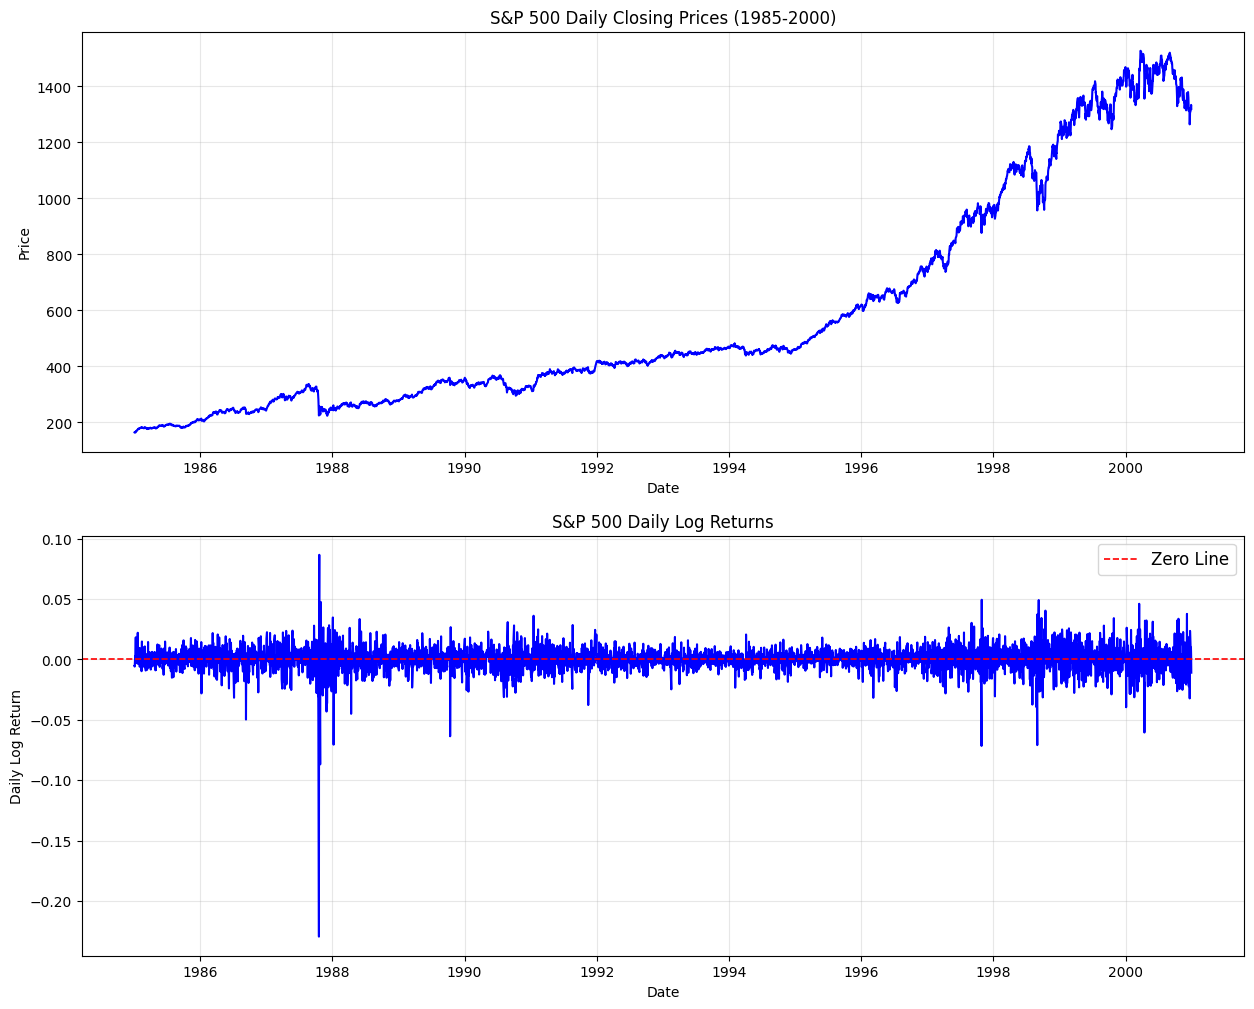

In [11]:
plt.figure(figsize=(15, 12))

# Plot S&P 500 daily closing prices
plt.subplot(2,1,1)
plt.plot(sp500_data['Adj Close'], color='blue')
plt.title("S&P 500 Daily Closing Prices (1985-2000)")
plt.xlabel("Date")
plt.ylabel("Price")
plt.grid(alpha=0.3)

# Plot daily log returns
plt.subplot(2,1,2)
plt.plot(sp500_data['Daily Log Return'], color='blue')
plt.axhline(y=0, color='red', linestyle='--', linewidth=1.2, label='Zero Line')
plt.legend(fontsize=12)
plt.title("S&P 500 Daily Log Returns")
plt.xlabel("Date")
plt.ylabel("Daily Log Return")
plt.grid(alpha=0.3)

plt.show()

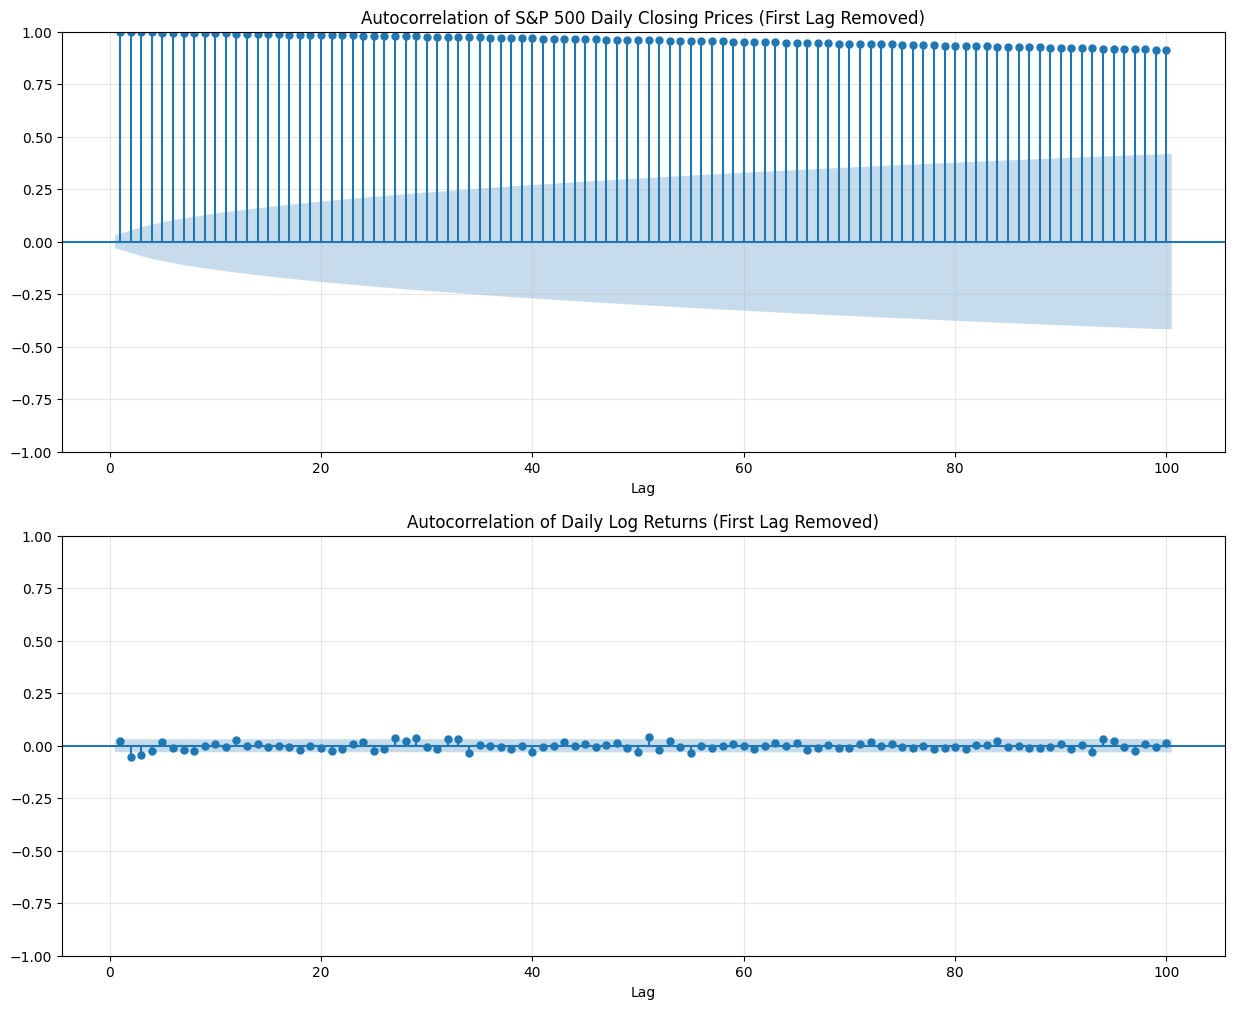

In [12]:
plt.figure(figsize=(15, 12))

# Autocorrelation of S&P 500 daily closing prices
plt.subplot(2, 1, 1)
plot_acf(sp500_data['Adj Close'], lags=100, zero=False, ax=plt.gca())
plt.title("Autocorrelation of S&P 500 Daily Closing Prices (First Lag Removed)")
plt.xlabel("Lag")
plt.grid(alpha=0.3)

# Autocorrelation of daily log returns
plt.subplot(2, 1, 2)
plot_acf(sp500_data['Daily Log Return'], lags=100, zero=False, ax=plt.gca())
plt.title("Autocorrelation of Daily Log Returns (First Lag Removed)")
plt.xlabel("Lag")
plt.grid(alpha=0.3)

plt.show()

### GARCH(1,1) Under Normality Assumption

#### Model Definition
The GARCH(1,1) model is defined as:

$$
r_t = \sigma_t z_t, \quad z_t \sim N(0, 1)
$$

$$
\sigma_t^2 = \omega + \alpha r_{t-1}^2 + \beta \sigma_{t-1}^2
$$

Where:
- $r_t$ = return at time $t$
- $\sigma_t^2$ = conditional variance of $r_t$
- $z_t$ = standard normal random variable
- $\mathcal{F}_{t-1}$ = information set up to time $t-1$

Typical constraints:
- $\omega > 0, \alpha \geq 0, \beta \geq 0$, and $\alpha + \beta < 1$

---

#### Derive the PDF of $r_t \mid \mathcal{F}_{t-1}$

Since $z_t \sim N(0, 1)$, we have:

$$
r_t \mid \mathcal{F}_{t-1} \sim N(0, \sigma_t^2)
$$

#### General PDF of a Normal Distribution
The probability density function (PDF) of a normal random variable is given by:

$$
f(r_t \mid \mathcal{F}_{t-1}) = \frac{1}{\sqrt{2\pi \sigma_t^2}} \exp\left(-\frac{r_t^2}{2\sigma_t^2}\right)
$$

#### Log-Likelihood Function

The likelihood function for $T$ observations is:

$$
L(\theta) = \prod_{t=1}^T f(r_t \mid \mathcal{F}_{t-1})
$$

where $\theta = (\omega, \alpha, \beta)$. Taking the logarithm:

$$
\ell(\theta) = \ln L(\theta) = \sum_{t=1}^T \ln f(r_t \mid \mathcal{F}_{t-1})
$$

Substituting the PDF:

$$
\ell(\theta) = \sum_{t=1}^T \left[ -\frac{1}{2} \ln(2\pi) - \frac{1}{2} \ln(\sigma_t^2) - \frac{r_t^2}{2\sigma_t^2} \right]
$$

Finally, we maximize the log-likelihood with respect to the parameters $\omega$, $\alpha$, and $\beta$, which determine $\sigma_t^2$, using a numerical optimization approach (as no closed-form solution generally exists for $\omega$, $\alpha$, and $\beta$).

Once $\omega$, $\alpha$, and $\beta$ are estimated, $\sigma_t^2$ can be computed recursively, starting with initial values for $\sigma_1^2$ and $r_1^2$, such as the sample variance of the log-returns.



### GARCH(1,1) Function

In this script, `t` consistently represents a **time step**, aligning with standard mathematical notation in time series models. To avoid confusion and conflicts, we used `from scipy.stats import t as t_distribution` at the beginning.

In [13]:
def garch_normal_log_likelihood(parameters, returns):
    """
    Calculate the negative log-likelihood for a GARCH(1,1) model under normality assumption.

    Inputs:
    - parameters (list or array): Model parameters [omega, alpha, beta]
      - omega (float): The constant term in the GARCH model
      - alpha (float): The coefficient for the lagged squared returns
      - beta (float): The coefficient for the lagged variance
    - returns (array): A 1D array of asset returns

    Outputs:
    - float: The negative log-likelihood value for the GARCH(1,1) model under normality assumption.
    """
    # Unpack parameters
    omega, alpha, beta = parameters
    # Number of observations
    T = len(returns)
    # Initialize the variance array and set the first value to the sample variance
    variance = np.zeros(T)
    variance[0] = np.var(returns)
    # Initialize log-likelihood
    log_likelihood = 0

    # Iterate over returns to calculate the GARCH(1,1) variance and log-likelihood
    for t in range(1, T):
        variance[t] = omega + alpha * (returns[t - 1]) ** 2 + beta * variance[t - 1]
        log_likelihood += -0.5 * (
            np.log(2 * np.pi) + np.log(variance[t]) + (returns[t]) ** 2 / variance[t]
        )

    # Return the negative log-likelihood (minimization objective)
    return -log_likelihood


def fit_garch_normal_model(returns):
    """
    Fit a GARCH(1,1) model to the provided returns using maximum likelihood estimation.

    Inputs:
    - returns (array): A 1D array of asset returns

    Outputs:
    - parameters (array): The estimated model parameters [omega, alpha, beta]
    - standard_errors (array): The standard errors of the estimated parameters
    - filtered_variance (array): A 1D array of the conditional variances computed using the fitted GARCH(1,1) model
    """
    # Initial parameter guesses for optimization
    initial_parameter_guess = [0.01, 0.08, 0.89]

    # Bounds for the parameters to ensure valid GARCH(1,1) estimates
    bounds = [
        (1e-8, np.inf),     # omega must be positive
        (0, 1),             # alpha must be between 0 and 1
        (0, 1)              # beta must be between 0 and 1
    ]

    # Minimize the negative log-likelihood function using the 'L-BFGS-B' method
    result = minimize(
        garch_normal_log_likelihood, 
        initial_parameter_guess,
        args=(returns,),  # Pass returns as an argument to the likelihood function
        bounds=bounds,
        method='L-BFGS-B'  # Optimization method
    )

    # Extract the estimated parameters from the optimization result
    parameters = result.x

    # Compute the inverse of the Hessian to calculate parameter standard errors
    hessian_inverse = (
        result.hess_inv.todense() if hasattr(result.hess_inv, "todense") else np.linalg.inv(result.hess_inv)
    )
    standard_errors = np.sqrt(np.diag(hessian_inverse))

    # Unpack parameters for easier interpretation
    omega, alpha, beta = parameters

    # Filter the conditional variances using the GARCH(1,1) recursion
    T = len(returns)
    filtered_variance = np.zeros(T)  # Initialize variance array
    filtered_variance[0] = np.var(returns)  # Set the initial variance to the sample variance

    # Apply the GARCH(1,1) variance equation recursively
    for t in range(1, T):
        filtered_variance[t] = omega + alpha * (returns[t - 1]) ** 2 + beta * filtered_variance[t - 1]

    # Return the estimated parameters, their standard errors, and the filtered variances
    return parameters, standard_errors, filtered_variance

In [14]:
# Call the function
parameters, standard_errors, filtered_variance = fit_garch_normal_model(returns)

# Display estimated parameters
print("Estimated Parameters:")
print(f"omega: {parameters[0]:.6f}")
print(f"alpha: {parameters[1]:.6f}")
print(f"beta: {parameters[2]:.6f}")

# Display standard errors
print("\nStandard Errors:")
print(f"{standard_errors[0]:.6f}")
print(f"{standard_errors[1]:.6f}")
print(f"{standard_errors[2]:.6f}")

# Display the first 10 values of the filtered variance process
print("\nFiltered Variance (First 10 Values):")
for i in range(10):
    print(f"Day {i + 1}: {filtered_variance[i]:.6f}")

Estimated Parameters:
omega: 0.000001
alpha: 0.086507
beta: 0.905270

Standard Errors:
0.011749
0.303947
156.826318

Filtered Variance (First 10 Values):
Day 1: 0.000109
Day 2: 0.000103
Day 3: 0.000097
Day 4: 0.000090
Day 5: 0.000084
Day 6: 0.000081
Day 7: 0.000103
Day 8: 0.000096
Day 9: 0.000107
Day 10: 0.000098


### Simulation Logic

Simulation:
   - Start with filtered variance ($\sigma_t^2$) for each day
   - Generate random shocks $z_t \sim N(0,1)$ and compute returns $r_t = \sigma_t \cdot z_t \, (\sigma_t \text{ is the square root of the filtered variance})$
   - Update variance using GARCH(1,1) $ \sigma_t^2 = \omega + \alpha r_t^2 + \beta \sigma_t^2 $ with previously estimated parameters and repeat the loop for 30 days
   - Repeat this for each day of the sample
        
Alignment:
   - Each simulated return contributes to calculating the confidence intervals, violation rate and plotting
   - Align values to their corresponding respective days using `simulated_returns_aligned`

Output:
- `simulated_returns`: A matrix where each row represents a 30 day forward simulation path, with this process repeated for every day in the sample
- `simulated_returns_aligned`: A list where each index corresponds to a specific day $t$, aggregating all simulated returns that align with that actual day 

In [15]:
# Set a seed for reproducibility
np.random.seed(123)

# GARCH parameters
omega = parameters[0]
alpha = parameters[1]
beta = parameters[2]

sample_days = len(returns)  # We repeat simulations for each day in our sample
prediction_period = 30 

# Initialize array to store simulated returns
simulated_returns = np.zeros((sample_days, prediction_period))  
simulated_returns_aligned = [[] for _ in range(sample_days)]  # List to store overlapping simulations for each day

# Simulate returns for each day in the dataset
for day in range(sample_days):
    filtered_variance_simulated = filtered_variance[day]  # Use day's filtered variance as the starting variance
    simulated_returns_temporary = []  # Temporary variable to store returns for this day
    
    for t in range(prediction_period):
        z_t_simulated = np.random.normal(0, 1)  
        r_t_simulated = np.sqrt(filtered_variance_simulated) * z_t_simulated  
        simulated_returns_temporary.append(r_t_simulated)  # Store in the temporary list
        
        # Update variance using GARCH(1,1) formula
        filtered_variance_simulated = omega + alpha * (r_t_simulated ** 2) + beta * filtered_variance_simulated  
        
        # Align values (add this simulated return to the corresponding day in simulated_returns_aligned)
        if day + t < sample_days:  # Ensure no out-of-bounds indexing
            simulated_returns_aligned[day + t].append(r_t_simulated)
    
    # Store simulated returns for the day
    simulated_returns[day, :] = simulated_returns_temporary

### Confidence Interval and Violation Rate

As we simulated the returns, we use percentiles to estimate the confidence interval (CI), without making any distributional assumption.
The main steps are described below. 

Confidence Interval:
   - The 95% CI is constructed using the 2.5th percentile as the lower bound and the 97.5th percentile as the upper bound, capturing 95% of the empirical distribution of the simulated returns
   
Counting Violations:
   - A violation occurs if the observed return ($r_t$) falls outside the confidence interval
     $ r_t < \text{Lower Bound} \quad \text{or} \quad r_t > \text{Upper Bound} $
   - Iterate over all days in the sample and count the total number of violations

Output:
- `lower_bounds_percentile` and `upper_bounds_percentile`: Arrays containing the confidence interval bounds for each day
- `violations_percentile`: Total number of days where the observed return falls outside the confidence interval
- `violation_rate_percentile`: The percentage of days with violations, calculated as
$ \text{Violation Rate} = \frac{\text{Total Violations}}{\text{Total Sample Days}} \times 100 $

In [16]:
# Initialize variables
lower_bounds_percentile = np.zeros(sample_days)
upper_bounds_percentile = np.zeros(sample_days)
violations_percentile = 0

# Calculate percentile-based CIs and check for violations
for day in range(sample_days):
    if simulated_returns_aligned[day]:  # Ensure there are aligned values
        simulated_values = np.array(simulated_returns_aligned[day])
        
        # Compute lower and upper bounds using percentiles
        lower_bounds_percentile[day] = np.percentile(simulated_values, 2.5)
        upper_bounds_percentile[day] = np.percentile(simulated_values, 97.5)
        
        # Check for violation
        if returns[day] < lower_bounds_percentile[day] or returns[day] > upper_bounds_percentile[day]:
            violations_percentile += 1

# Calculate violation rate
violation_rate_percentile = violations_percentile / sample_days
print(f"Percentile-Based Violation Rate: {violation_rate_percentile:.2%}")

Percentile-Based Violation Rate: 7.89%


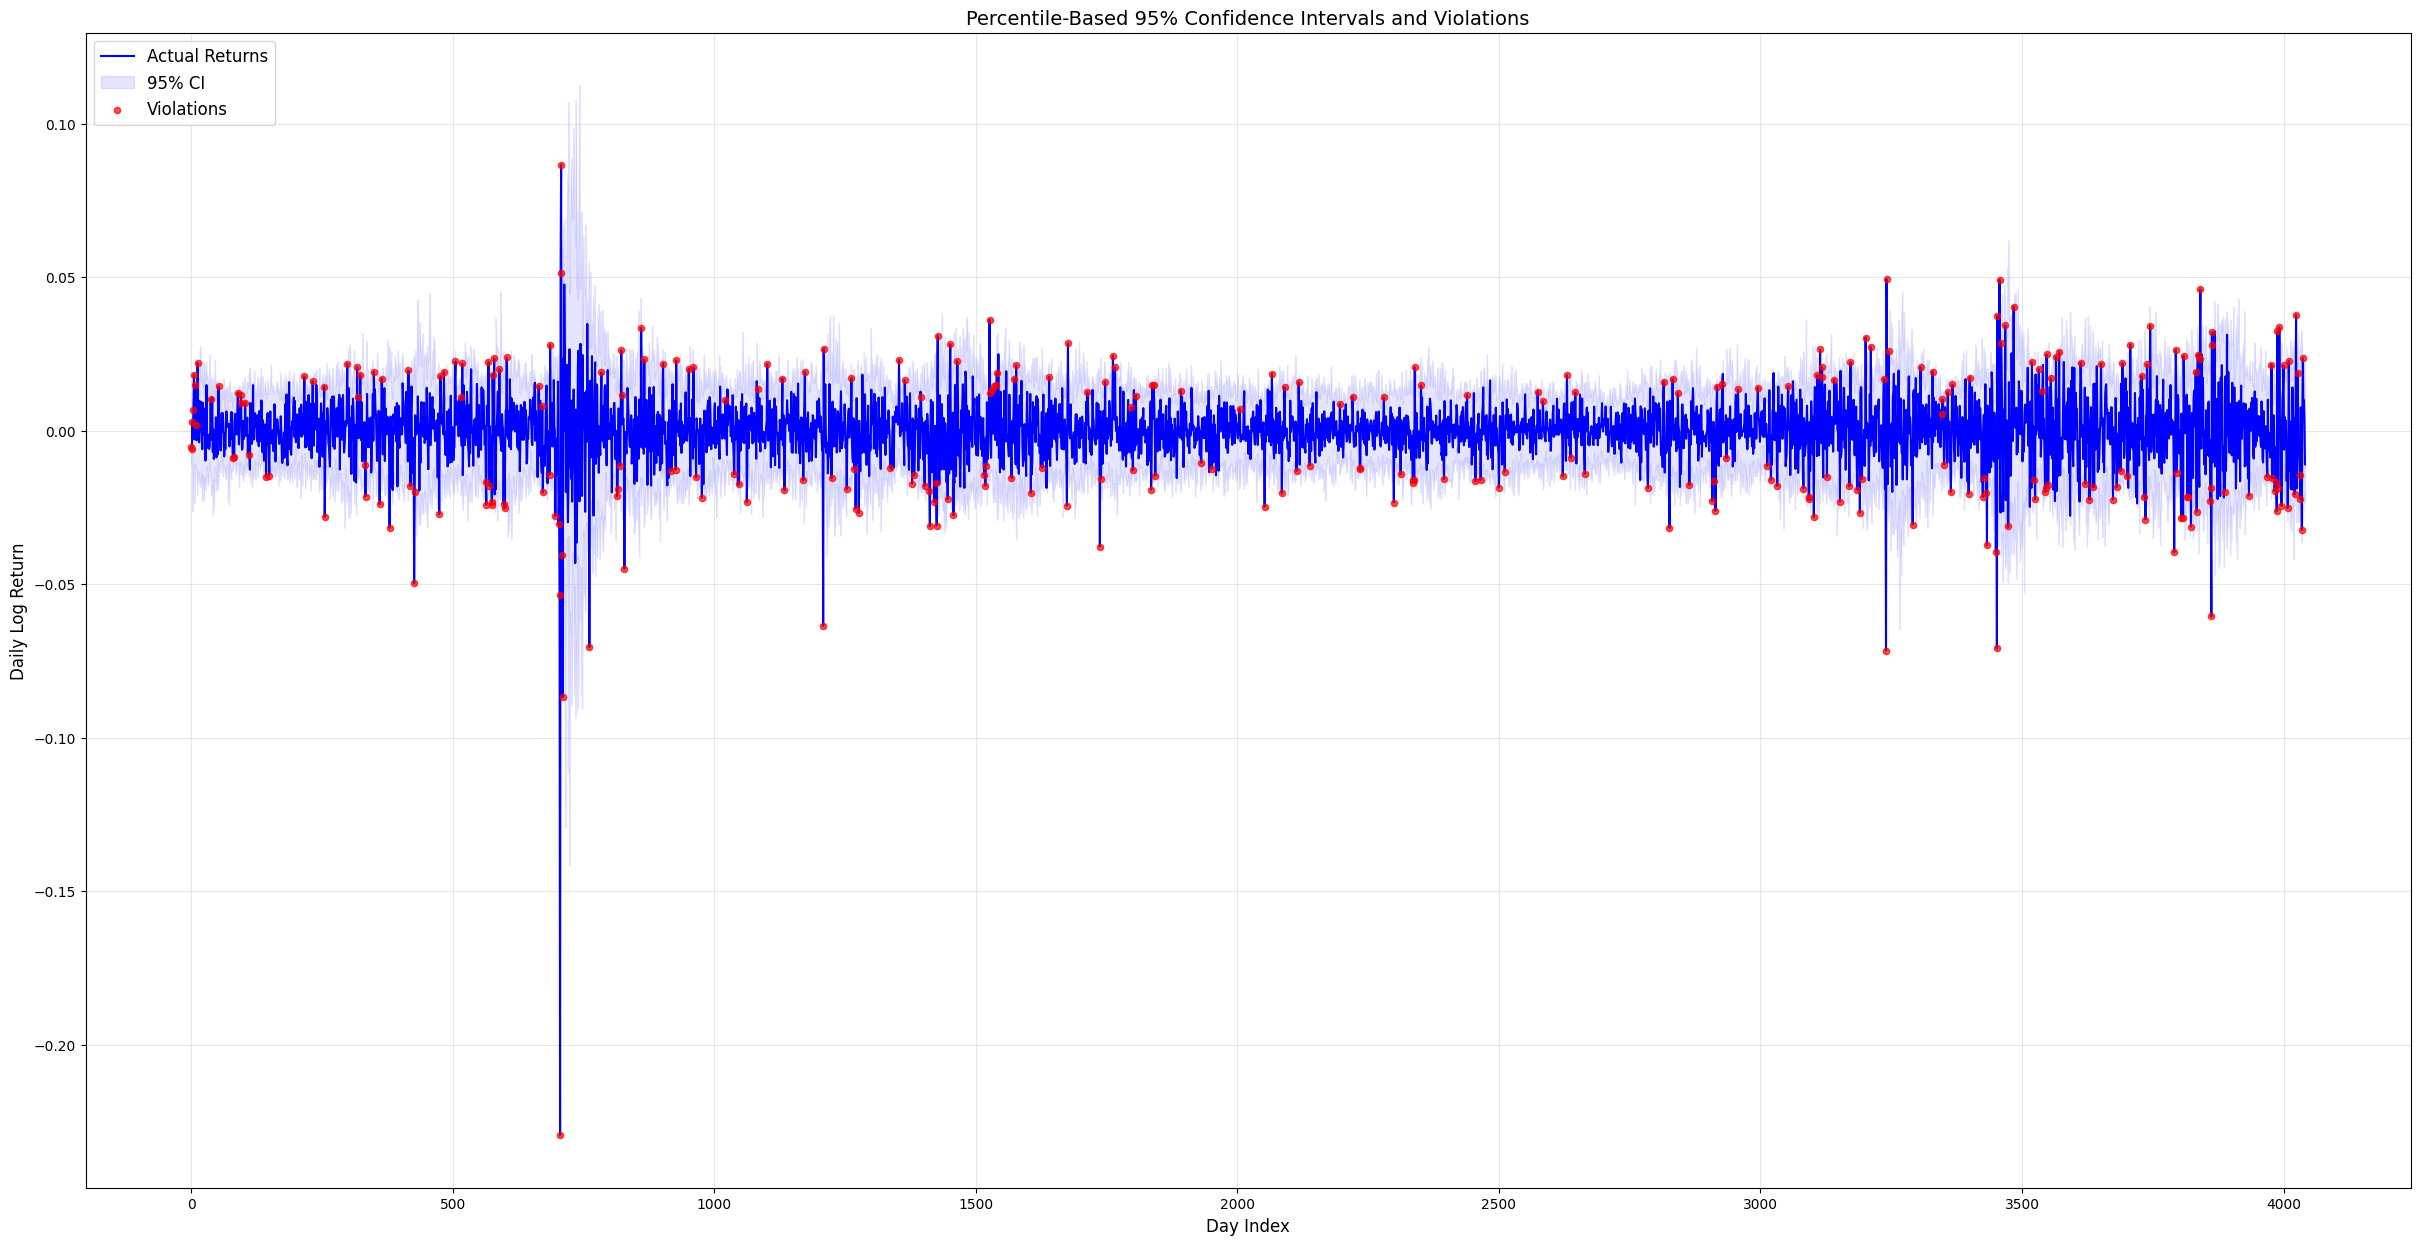

In [17]:
plt.figure(figsize=(30, 15))

# Percentile-Based CI
plt.plot(range(sample_days), returns, label="Actual Returns", color="blue", linewidth=1.5)
plt.fill_between(range(sample_days), lower_bounds_percentile, upper_bounds_percentile, color="blue", alpha=0.1, label="95% CI")
violation_days = np.where((returns < lower_bounds_percentile) | (returns > upper_bounds_percentile))[0]
plt.scatter(violation_days, returns[violation_days], color="red", alpha=0.7, label="Violations", zorder=5, s=20)
plt.title("Percentile-Based 95% Confidence Intervals and Violations", fontsize=14)
plt.xlabel("Day Index", fontsize=12)
plt.ylabel("Daily Log Return", fontsize=12)
plt.legend(fontsize=12, loc="upper left")
plt.grid(alpha=0.3)

plt.show()

### Returns Distribution

In this second part of the study, we aim to fit a GARCH(1,1) model with student's t-distributed shocks. We begin by examining the distributions of the returns and empirical shocks, which often exhibit "heavy tails", indicating deviations from normality. This is true in our case, and they are also clearly asymmetric.

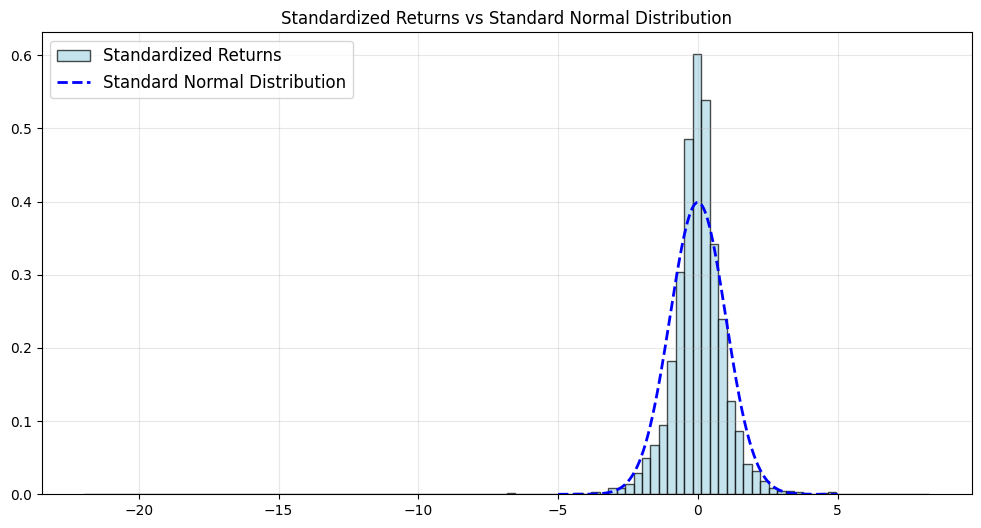

In [18]:
# Standardize the returns
mean_returns = np.mean(returns)
std_returns = np.std(returns)
standardized_returns = (returns - mean_returns) / std_returns

# Define the standard normal distribution
x = np.linspace(-5, 5, 1000)
normal_pdf = norm.pdf(x)  

plt.figure(figsize=(12, 6))

plt.hist(
    standardized_returns, 
    bins=100,  
    density=True, 
    color='lightblue', 
    alpha=0.7,  
    label='Standardized Returns',
    edgecolor='black'  
)

# Plot the standard normal distribution
plt.plot(x, normal_pdf, 'b--', linewidth=2, label='Standard Normal Distribution')

# Add labels, legend, and grid
plt.title('Standardized Returns vs Standard Normal Distribution')
plt.legend(fontsize=12)
plt.grid(alpha=0.3)

plt.show()

### Innovations Distribution
The GARCH model innovations show significantly less volatility clustering compared to market returns. Additionally, the histogram indicates that the innovations deviate from a normal distribution.

In [19]:
# Compute innovations
innovations = returns / np.sqrt(filtered_variance)  

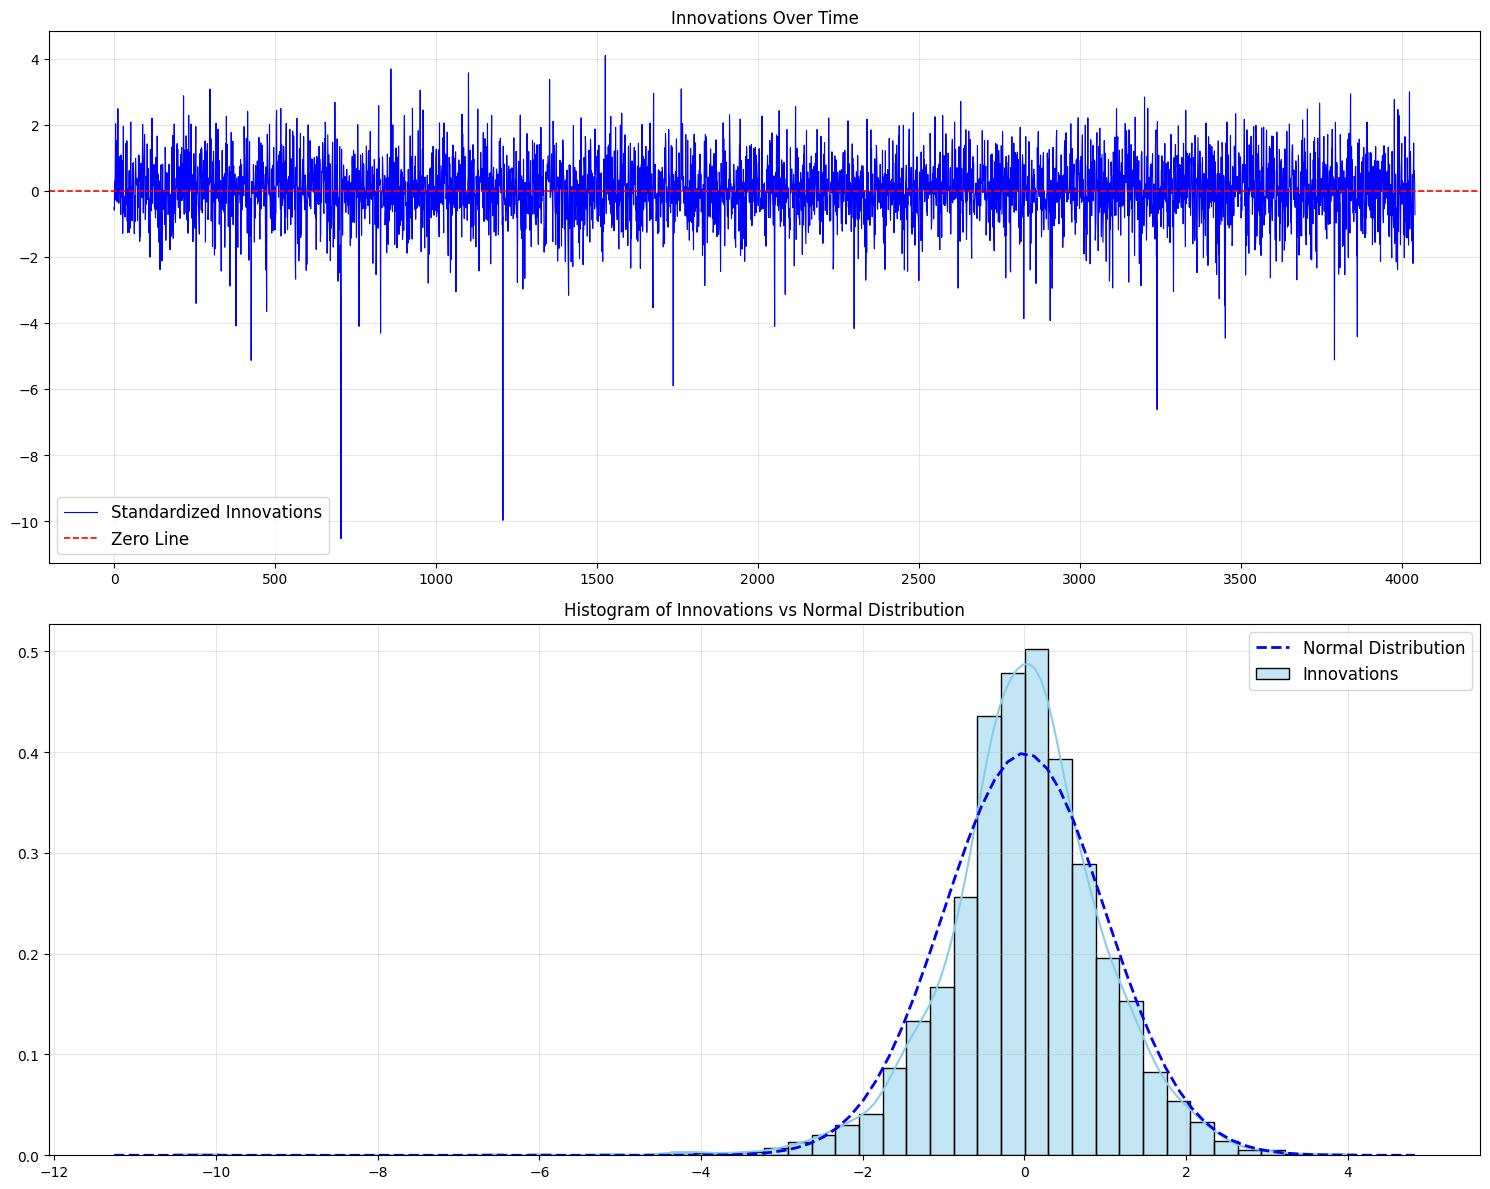

In [20]:
plt.figure(figsize=(15, 12))

# Plot innovations over time
plt.subplot(2, 1, 1)
plt.plot(innovations, color='blue', linewidth=0.8, label='Standardized Innovations')
plt.axhline(y=0, color='red', linestyle='--', linewidth=1.2, label='Zero Line')
plt.title("Innovations Over Time")
plt.grid(alpha=0.3)
plt.legend(fontsize=12)

# Histogram of innovations vs normal distribution
plt.subplot(2, 1, 2)
sns.histplot(innovations, bins=50, kde=True, stat="density", color='skyblue', label="Innovations")
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, 0, 1)  
plt.plot(x, p, 'b--', linewidth=2, label="Normal Distribution")
plt.title("Histogram of Innovations vs Normal Distribution")
plt.ylabel('')
plt.grid(alpha=0.3)
plt.legend(fontsize=12)

# Adjust layout and show the plots
plt.tight_layout()
plt.show()

### GARCH(1,1) Under Student's t Assumption

Given these observations, we proceed with a GARCH(1,1) under the assumption of a student's t-distribution. We define the functions distinctly each time, but overwrite the parameters for simplicity and improved readability.

#### Model Definition

The GARCH(1,1) model becomes:

$$
r_t = \sigma_t z_t, \quad z_t \sim t_\nu,
$$

$$
\sigma_t^2 = \omega + \alpha r_{t-1}^2 + \beta \sigma_{t-1}^2
$$

Where:
- $t_\nu$: Student-$t$ distribution with $\nu$ degrees of freedom

#### Log-Likelihood Function

The log-likelihood function for the GARCH(1,1) model under student’s t innovations is given by:

$$
\ell(\theta, \nu) = \sum_{t=1}^T \left[ \ln \Gamma\left(\frac{\nu+1}{2}\right) - \ln \Gamma\left(\frac{\nu}{2}\right) - \frac{1}{2} \ln((\nu-2) \pi) - \frac{1}{2} \ln(\sigma_t^2) - \frac{\nu+1}{2} \ln\left(1 + \frac{r_t^2}{(\nu-2) \sigma_t^2}\right) \right]
$$

Here, the adjustment with $(\nu - 2)$ ensures that the variance of the student's $t$ distribution is finite when $\nu > 2$

### Garch(1,1) Function Revisited 

In [21]:
def garch_students_t_log_likelihood(parameters, returns):
    """
    Calculate the negative log-likelihood for a GARCH(1,1) model under the student's t-distribution assumption.

    Inputs:
    - parameters (list or array): Model parameters [omega, alpha, beta, nu]
      - omega (float): The constant term in the GARCH model
      - alpha (float): The coefficient for the lagged squared returns
      - beta (float): The coefficient for the lagged variance
      - nu (float): The degrees of freedom for the student's t-distribution
    - returns (array): A 1D array of asset returns

    Outputs:
    - float: The negative log-likelihood value for the GARCH(1,1) model with the student's t-distribution
    """
    # Unpack parameters
    omega, alpha, beta, nu = parameters

    # Number of observations
    T = len(returns)
    # Initialize the variance array and set the first value to the sample variance
    variance = np.zeros(T)
    variance[0] = np.var(returns)
    # Initialize log-likelihood
    log_likelihood = 0

    # Iterate over returns to calculate the GARCH(1,1) variance and log-likelihood
    for t in range(1, T):
        variance[t] = omega + alpha * (returns[t - 1]) ** 2 + beta * variance[t - 1]
        log_likelihood += (
            gammaln((nu + 1) / 2)
            - gammaln(nu / 2)
            - 0.5 * np.log(np.pi * (nu - 2))
            - 0.5 * np.log(variance[t])
            - ((nu + 1) / 2) * np.log(1 + (returns[t] ** 2) / ((nu - 2) * variance[t]))
        )

    # Return the negative log-likelihood (minimization objective)
    return -log_likelihood


def fit_garch_students_t_model(returns):
    """
    Fit a GARCH(1,1) model with the student's t-distribution to the provided returns. 

    Inputs:
    - returns (array): A 1D array of asset returns

    Outputs:
    - parameters (array): The estimated model parameters [omega, alpha, beta, nu]
    - standard_errors (array): The standard errors of the estimated parameters
    - filtered_variance (array): A 1D array of the conditional variances computed using the fitted GARCH(1,1) model
    """
    # Initial parameter guesses for optimization
    initial_parameter_guess = [0.001, 0.05, 0.9, 5]  # Add an initial guess for nu

    # Bounds for the parameters to ensure valid GARCH(1,1) estimates
    bounds = [
        (1e-8, np.inf),     # omega must be positive
        (0, 1),             # alpha must be between 0 and 1
        (0, 1),             # beta must be between 0 and 1
        (2 + 1e-8, np.inf)  # nu > 2 for the t-distribution to be well-defined
    ]

    # Minimize the negative log-likelihood function using the 'L-BFGS-B' method
    result = minimize(
        garch_students_t_log_likelihood,
        initial_parameter_guess,
        args=(returns,),  # Pass returns as an argument to the likelihood function
        bounds=bounds,
        method='L-BFGS-B'  # Optimization method
    )

    # Extract the estimated parameters from the optimization result
    parameters = result.x

    # Compute the inverse of the Hessian to calculate parameter standard errors
    hessian_inverse = (
        result.hess_inv.todense() if hasattr(result.hess_inv, "todense") else np.linalg.inv(result.hess_inv)
    )
    standard_errors = np.sqrt(np.diag(hessian_inverse))

    # Unpack parameters for easier interpretation
    omega, alpha, beta, nu = parameters

    # Filter the conditional variances using the GARCH(1,1) recursion
    T = len(returns)
    filtered_variance = np.zeros(T)  # Initialize variance array
    filtered_variance[0] = np.var(returns)  # Set the initial variance to the sample variance

    # Apply the GARCH(1,1) variance equation recursively
    for t in range(1, T):
        filtered_variance[t] = omega + alpha * (returns[t - 1]) ** 2 + beta * filtered_variance[t - 1]

    # Return the estimated parameters, their standard errors, and the filtered variances
    return parameters, standard_errors, filtered_variance

In [22]:
# Call the function
parameters, standard_errors, filtered_variance = fit_garch_students_t_model(returns)

# Display estimated parameters
print("Estimated Parameters:")
print(f"omega: {parameters[0]:.6f}")
print(f"alpha: {parameters[1]:.6f}")
print(f"beta: {parameters[2]:.6f}")
print(f"nu(degrees of freedom): {parameters[3]:.6f}")

# Display standard errors
print("\nStandard Errors:")
print(f"{standard_errors[0]:.6f}")
print(f"{standard_errors[1]:.6f}")
print(f"{standard_errors[2]:.6f}")
print(f"{standard_errors[3]:.6f}")

# Display the first 10 values of the filtered variance process
print("\nFiltered Variance (First 10 Values):")
for i in range(10):
    print(f"Day {i + 1}: {filtered_variance[i]:.6f}")

Estimated Parameters:
omega: 0.000001
alpha: 0.051142
beta: 0.943845
nu(degrees of freedom): 5.068682

Standard Errors:
0.000678
7.111004
23.076525
424.606031

Filtered Variance (First 10 Values):
Day 1: 0.000109
Day 2: 0.000105
Day 3: 0.000102
Day 4: 0.000097
Day 5: 0.000093
Day 6: 0.000090
Day 7: 0.000103
Day 8: 0.000098
Day 9: 0.000105
Day 10: 0.000100


### Simulation Logic

This process is exactly identical to the normal GARCH simulation, but we use the parameters estimated from the student's t-GARCH model and draw shocks from the student's t-distribution instead of the normal distribution.

In [23]:
# Set a seed for reproducibility
np.random.seed(123)

# New GARCH parameters
omega = parameters[0]
alpha = parameters[1]
beta = parameters[2]
nu = parameters[3]  

# Simulation setup
sample_days = len(returns)  # We repeat simulations for each day in our sample
prediction_period = 30  # Number of days for forward predictions

# Initialize array to store simulated returns
simulated_returns = np.zeros((sample_days, prediction_period))  
simulated_returns_aligned = [[] for _ in range(sample_days)]  # List to store overlapping simulations for each day

# Simulate returns for each day in the dataset
for day in range(sample_days):
    filtered_variance_simulated = filtered_variance[day]  # Use day's filtered variance as the starting variance
    simulated_returns_temporary = []  # Temporary variable to store returns for this day
    
    for t in range(prediction_period):
        # Generate random shocks from a standardized student's t-distribution
        z_t_simulated = np.random.standard_t(nu)  # Random variable with student's t-distribution
        r_t_simulated = np.sqrt(filtered_variance_simulated) * z_t_simulated  # Simulate return with current variance
        
        simulated_returns_temporary.append(r_t_simulated)  # Store in the temporary list
        
        # Update variance using the GARCH(1,1) formula
        filtered_variance_simulated = omega + alpha * (r_t_simulated ** 2) + beta * filtered_variance_simulated  # GARCH recursion
        
        # Align values (add this simulated return to the corresponding day in simulated_returns_aligned)
        if day + t < sample_days:  # Ensure no out-of-bounds indexing
            simulated_returns_aligned[day + t].append(r_t_simulated)
    
    # Store simulated returns for the day
    simulated_returns[day, :] = simulated_returns_temporary

### Confidence Interval and Violation Rate 
Once again this process is identical to the normal GARCH case, so we overwrite for simplicity and readability.

In [24]:
# Initialize variables
lower_bounds_percentile = np.zeros(sample_days)
upper_bounds_percentile = np.zeros(sample_days)
violations_percentile = 0

# Calculate percentile-based CIs and check for violations
for day in range(sample_days):
    if simulated_returns_aligned[day]:  # Ensure there are aligned values
        simulated_values = np.array(simulated_returns_aligned[day])
        
        # Compute lower and upper bounds using percentiles
        lower_bounds_percentile[day] = np.percentile(simulated_values, 2.5)
        upper_bounds_percentile[day] = np.percentile(simulated_values, 97.5)
        
        # Check for violation
        if returns[day] < lower_bounds_percentile[day] or returns[day] > upper_bounds_percentile[day]:
            violations_percentile += 1

# Calculate violation rate
violation_rate_percentile = violations_percentile / sample_days
print(f"Percentile-Based Violation Rate: {violation_rate_percentile:.2%}")

Percentile-Based Violation Rate: 2.82%


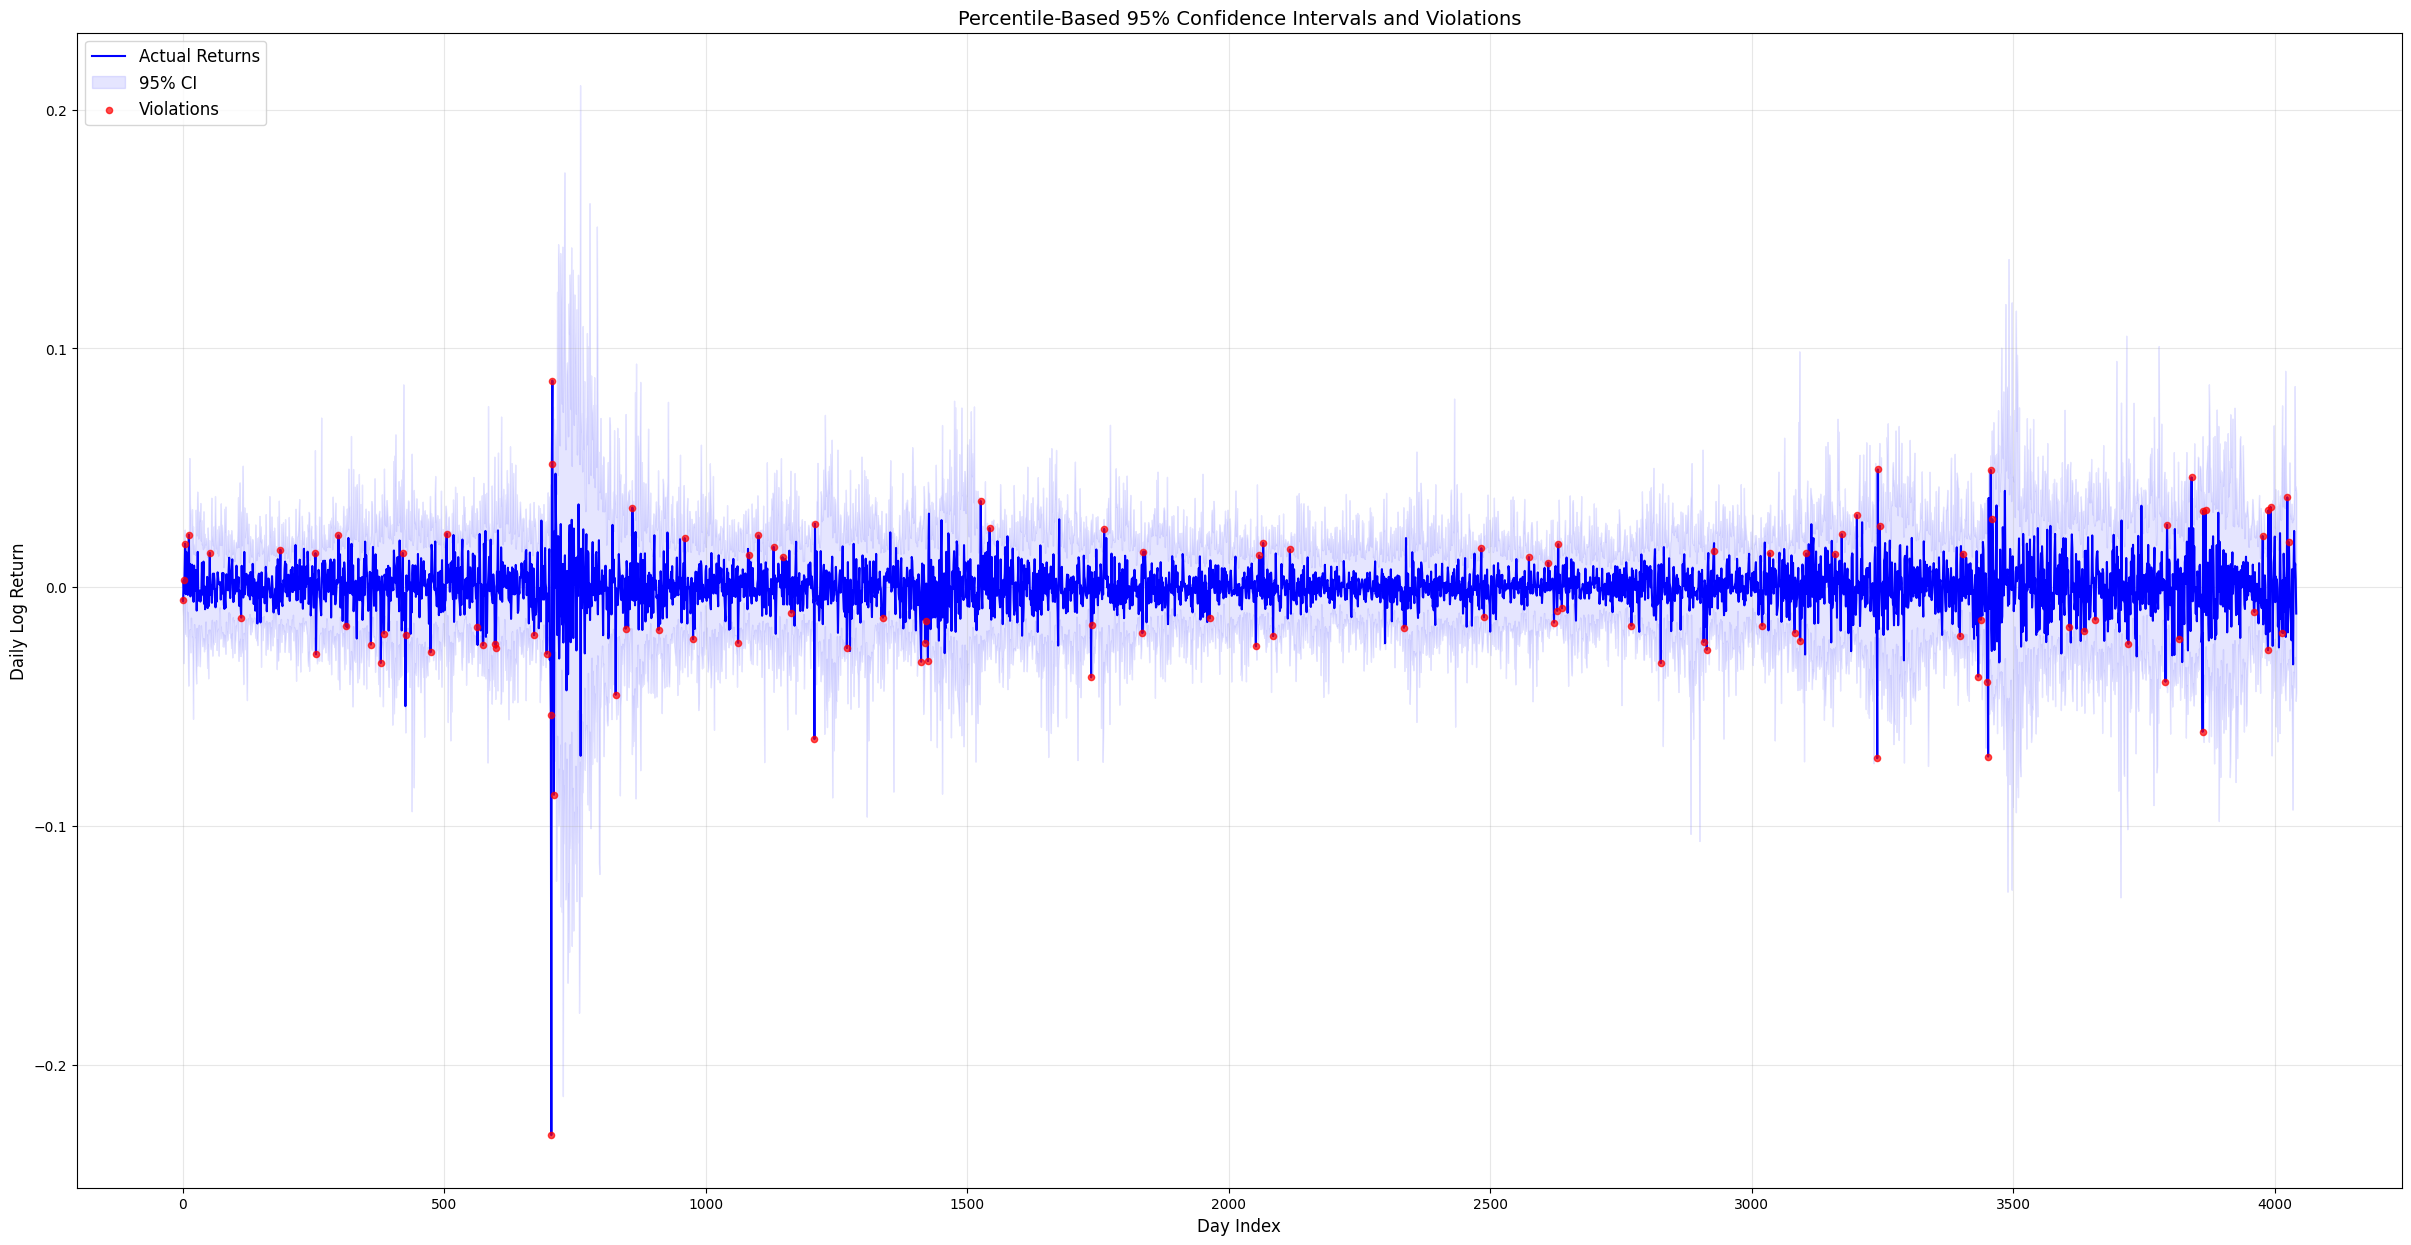

In [25]:
plt.figure(figsize=(30, 15))

# Percentile-Based CI
plt.plot(range(sample_days), returns, label="Actual Returns", color="blue", linewidth=1.5)
plt.fill_between(range(sample_days), lower_bounds_percentile, upper_bounds_percentile, color="blue", alpha=0.1, label="95% CI")
violation_days = np.where((returns < lower_bounds_percentile) | (returns > upper_bounds_percentile))[0]
plt.scatter(violation_days, returns[violation_days], color="red", alpha=0.7, label="Violations", zorder=5, s=20)
plt.title("Percentile-Based 95% Confidence Intervals and Violations", fontsize=14)
plt.xlabel("Day Index", fontsize=12)
plt.ylabel("Daily Log Return", fontsize=12)
plt.legend(fontsize=12, loc="upper left")
plt.grid(alpha=0.3)

plt.show()

### Innovations Distribution Revisited

In this section we offer a brief conclusion on confidence interval violations given our two approaches. If model assumptions were perfect, the violation rate for a 95% CI would be around 5%. However:
- **GARCH(1,1) with normal innovations**: Violation rate ~8%
- **GARCH(1,1) with student's t innovations**: Violation rate ~3%

These differences arise because actual returns are not normal. However, the confidence interval violations are based on shocks simulated from a normal or student's t distribution, with parameters estimated from a GARCH(1,1) model under these respective assumptions. The normal distribution misses extreme values more often, while the student's t-distribution better captures the heavy tails but slightly overcompensates. This behavior makes the estimated confidence intervals visibly larger as well. Our line of reasoning is visually supported by the following graph of innovations compared to a normal and student's t-distribution with the estimated degrees of freedom.

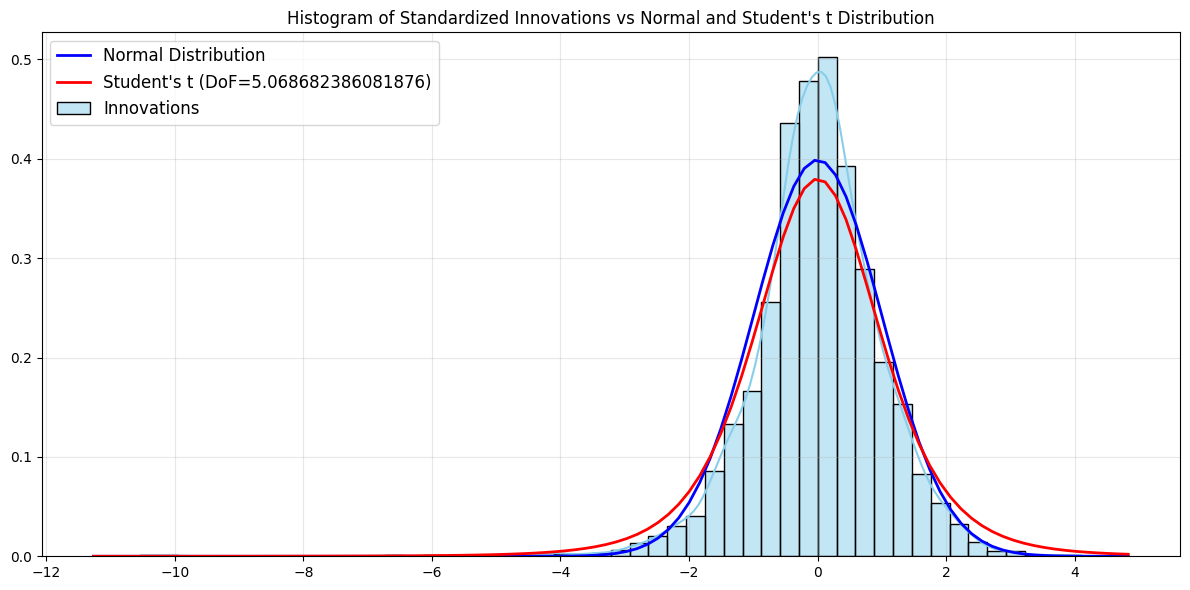

In [26]:
plt.figure(figsize=(12, 6))

# Histogram of innovations
sns.histplot(innovations, bins=50, kde=True, stat="density", color='skyblue', label="Innovations")

# Define x-axis range based on data
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)

# Normal distribution line 
pdf_normal = norm.pdf(x, 0, 1)  
plt.plot(x, pdf_normal, 'blue', linewidth=2, label="Normal Distribution")

# Student's t-distribution line with estimated degrees of freedom
nu = parameters[3]
pdf_student_t = t_distribution.pdf(x, df=nu)  
plt.plot(x, pdf_student_t, 'red', linewidth=2, label=f"Student's t (DoF={nu})")

# Add titles and labels
plt.title("Histogram of Standardized Innovations vs Normal and Student's t Distribution")
plt.ylabel('')  
plt.grid(alpha=0.3)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

### Appendix
To verify our calculations, we compare our results with the outputs from the Python GARCH package, initially under the normal distribution assumption and then with the student's 
t-distribution. In both cases, our estimated parameters align closely with the package results. However, the standard errors (SEs) from our implementation are less precise. These slight differences could be attributed to variations in scaling, parametrization, or numerical optimization techniques used in the package compared to our functions.
To further validate our approach, we estimate the degrees of freedom directly from the innovations using the package's fit method. Once again, our estimates are consistent with theoretical expectations and match the degrees of freedom inferred from the innovations.

In [27]:
# Rescale the returns to improve convergence
returns_scaled = returns * 100

# Fit a GARCH(1,1) model with normal distribution
model = arch_model(returns_scaled, vol='Garch', p=1, q=1)
result = model.fit(disp="off")  

# Print the summary of the results
print(result.summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                      y   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -5263.17
Distribution:                  Normal   AIC:                           10534.3
Method:            Maximum Likelihood   BIC:                           10559.6
                                        No. Observations:                 4042
Date:                Fri, Dec 13 2024   Df Residuals:                     4041
Time:                        15:52:33   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu             0.0167  1.428e-02      1.172      0.241 

In [28]:
# Fit a GARCH(1,1) model with student's t-distribution
model_t = arch_model(returns_scaled, vol='Garch', p=1, q=1, dist='t')
result_t = model_t.fit(disp="off")  

# Print the summary of the results
print(result_t.summary())

                        Constant Mean - GARCH Model Results                         
Dep. Variable:                            y   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:               -5054.68
Distribution:      Standardized Student's t   AIC:                           10119.4
Method:                  Maximum Likelihood   BIC:                           10150.9
                                              No. Observations:                 4042
Date:                      Fri, Dec 13 2024   Df Residuals:                     4041
Time:                              15:52:33   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
m

In [29]:
# Double check degrees of freedom using the fit method
student_t_parameters_innovations = t_distribution.fit(innovations)
estimated_nu = student_t_parameters_innovations[0]

print(f"Fitted Degrees of Freedom: {estimated_nu}")

Fitted Degrees of Freedom: 5.267286113509737
